# PCA and LDA method comparison
#### preparing sample

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg

data = pd.read_csv("data.csv")
data.head()
data = np.array(data)

def split_data( X, Y, Ntrain):
    d, N = X.shape
    idx = np.arange(N)
    np.random.shuffle(idx)

    X_train = X[:, idx[:Ntrain]]
    X_test = X[:, idx[Ntrain:]]
    Y_train = Y[idx[:Ntrain]]
    Y_test = Y[idx[Ntrain:]]
    return (X_train, Y_train), (X_test, Y_test)

def specify_sample(X, Y, dig):
    idx = Y == dig
    return (X[:, idx] , Y[idx])


In [3]:
digits = (0,6,9)

X = data[:, 1:].T
Y = data[:, 0]
print ("dataset divided:\nX = {}\nY = {}\n".format(X.shape, Y.shape))

digit_extract = [specify_sample(X, Y, dig) for dig in digits] #produces the form [(x0,y0),(x1,y1), .... ]

for i, dig in enumerate(digits):
    print("Found {} samples for number {}".format(digit_extract[i][1].shape[0], dig))

X = np.concatenate(tuple([digit_extract[i][0] for i in range(len(digits))]), axis=1)
Y = np.concatenate(tuple([digit_extract[i][1] for i in range(len(digits))]))


Ntrain = len(Y) // 6 * 4
(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, Ntrain)

print("\nTraining sample created with {} elements\nTest sample created with {} elements".format(X_train.shape[1], X_test.shape[1]))

D = X_train, Y_train
Dtest = X_test, Y_test

dataset divided:
X = (784, 42000)
Y = (42000,)

Found 4132 samples for number 0
Found 4137 samples for number 6
Found 4188 samples for number 9

Training sample created with 8304 elements
Test sample created with 4153 elements


#### Analysis

In [44]:
def PCA (D, k, option= 'V'):
    X, Y = D
    c_X = np.mean(X, 1)

    Xc = X- np.expand_dims(c_X, axis=1)
    U, s, VT = np.linalg.svd(Xc, full_matrices = False)
    
    Uk = U[:, :k]

    Zk = Uk.T@Xc
    
    C = np.array(  [ np.mean(Zk[:,Y==i],axis=1) for i in digits ]  )
    
    if option == 'V':
        plt.scatter(Zk[0], Zk[1], c = Y)
        plt.scatter(C[:, 0], C[:, 1], c = "black", s= 80)
        c_X = Uk.T@c_X
        plt.scatter(c_X[0], c_X[1], c="red", s=100)
    elif option != 'S':
        raise Exception("The option can only be 'V' for Verbose mode and 'S' for Silent mode")
    return Zk, Uk, C


def LDA(D, k, option= 'V'):
    X, Y = D
    d, N = X.shape
    XX = [X[:, Y == i] for i in digits]

    C = np.array([np.mean(XX[i], axis= 1) for i, dig in enumerate(digits)])

    c_X = np.mean(X, axis=1).reshape((784, 1))
    
    Xc = X - c_X

    X_w = np.concatenate(tuple([XX[i] - C[i].reshape((d, 1)) for i, dig in enumerate(digits)]), axis=1)
####
    Sw = X_w@X_w.T
####
    Xbar_i = [np.repeat(C[i].reshape(d, 1), XX[i].shape[1], axis= 1) for i, dig in enumerate(digits)]
    Xbar = np.concatenate(Xbar_i, axis=1)
    Xbarc = Xbar - c_X
    
    
    Sb = Xbarc@Xbarc.T
    
    try:
        L = np.linalg.cholesky(Sw)
    except: 
        epsilon = 1e-6
        Sw = Sw + epsilon * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)
    Linv = np.linalg.inv(L)
    lb, W = scipy.sparse.linalg.eigs(Linv@Sb@L, k)

    W = np.real(W)
    Q = Linv.T@W
    
    Z = Q.T@X
    
    C = np.array(  [ np.mean(Z[:,Y==i],axis=1) for i in digits ]  )
    if option == 'V':
        plt.scatter(Z[0,:], Z[1,:], c=Y)
        plt.scatter(C[:, 0], C[:, 1], c= "black", s= 80)
        c_X = Q.T@c_X
        plt.scatter(c_X[0], c_X[1], c="red", s=100)
    elif option != 'S':
        raise Exception("The option can only be 'V' for Verbose mode and 'S' for Silent mode")
    
    return Z, Q, C
    
def classify(x, Q, C):
    xp = Q.T@x
    dist = [np.linalg.norm(xp - C[i]) for i in range(len(C))]
    ind =  [i for i in range(len(C)) if dist[i] == min(dist)]
    return digits[ind[0]]
    
def accuracy(Y_true, Y_fit):
    comparison = Y_true==Y_fit
    return len(comparison[comparison == True])/len(comparison)

def average_distance(Z, Y, C):
    dist = [np.linalg.norm(Z[:, Y == dig] -  C[i]. reshape(C[i].shape[0], 1), 2, axis= 0) for i, dig in enumerate(digits)]
    avgdist = [np.mean(dist[i]) for i in range(len(dist))]
    return avgdist


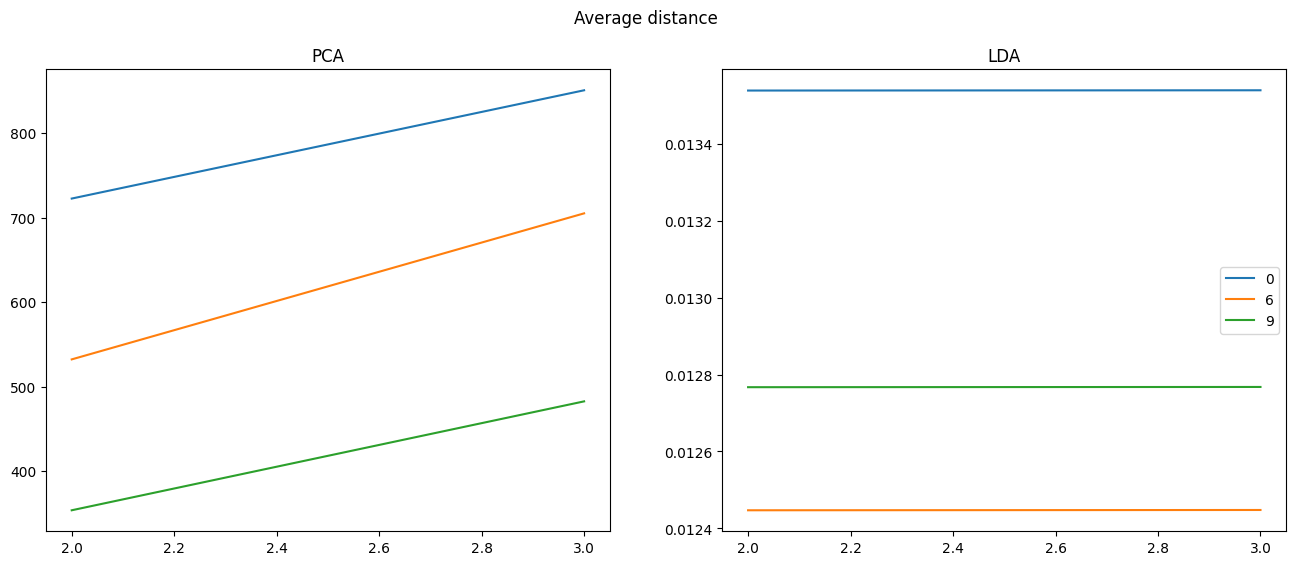

In [43]:
KK = np.arange(2, 4)
dist_PCA = np.zeros((len(digits), len(KK)))
dist_LDA = np.zeros((len(digits), len(KK)))

for k in KK:
    Zk, Q, C = PCA(D, k, 'S')
    avg = average_distance(Zk, D[1], C)
    for i, dig in enumerate(digits):
        dist_PCA[i, k - KK[0]]= avg[i]
    Zk, Q, C = LDA(D, k, 'S')
    avg = average_distance(Zk, D[1], C)
    for i, dig in enumerate(digits):
        dist_LDA[i, k - KK[0]]= avg[i]

plt.figure(figsize=(16, 6))
plt.suptitle("Average distance")
plt.subplot(1, 2, 1)
plt.title("PCA")
for i, dig in enumerate(digits):
    plt.plot(KK, dist_PCA[i])
plt.subplot(1, 2, 2)
plt.title("LDA")
for i, dig in enumerate(digits):
    plt.plot(KK, dist_LDA[i])
plt.legend([str(dig) for dig in digits])

plt.show()

[0 0 6 ... 6 9 0]


0.6414640019263184

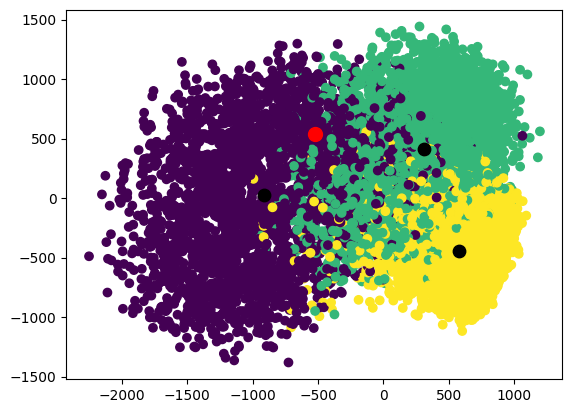

In [5]:
class_alg = "PCA"

if class_alg == "PCA":
    Zk, Q, C = PCA(D, 2)
elif class_alg == "LDA":
    Zk, Q, C = LDA(D, 2)

Yfit = np.array([classify(X_test[:, index_x], Q, C) for index_x in range(X_test.shape[1])])
print(Y_test)

accuracy(Y_true= Y_test, Y_fit= Yfit)

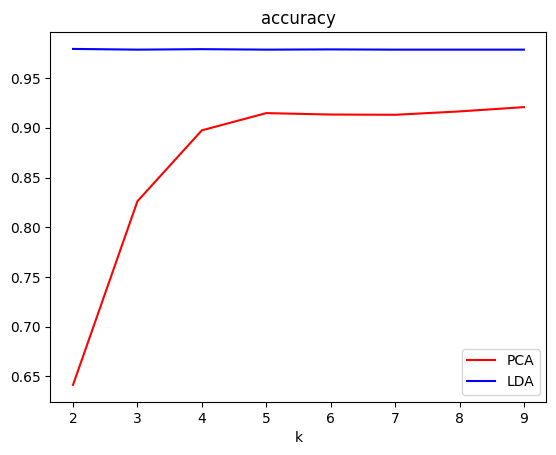

k	PCA	LDA
2	0.6415	0.9793
3	0.8261	0.9786
4	0.8974	0.9791
5	0.9148	0.9786
6	0.9133	0.9788
7	0.9131	0.9786
8	0.9164	0.9786
9	0.9208	0.9786


In [6]:
from IPython.display import clear_output
KK = np.arange(2, 10)
acc = np.zeros((2, len(KK)))

for k in KK:
    Zk, Q, C = PCA(D, k, 'S')
    Yfit = np.array([classify(X_test[:, index_x], Q, C) for index_x in range(X_test.shape[1])])
    acc[0, k - KK[0]] = accuracy(Y_true= Y_test, Y_fit= Yfit)
    print(f"PCA computed for k = {k}")
    
    Zk, Q, C = LDA(D, k, 'S')
    Yfit = np.array([classify(X_test[:, index_x], Q, C) for index_x in range(X_test.shape[1])])
    acc[1, k - KK[0]] = accuracy(Y_true= Y_test, Y_fit= Yfit)
    print(f"LDA computed for k = {k}")
clear_output(wait=True)

plt.figure()
plt.plot(KK, acc[0, :], c= "red")
plt.plot(KK, acc[1, :], c= "blue")
plt.title("accuracy")
plt.xlabel("k")
plt.legend(["PCA", "LDA"])
plt.show()
print("Accuracy:")
print("k\tPCA\tLDA")
for i, k in enumerate(KK):
    print(k, np.round(acc[0, i], 4), np.round(acc[1, i], 4), sep= "\t")


# Visualizing dyads


Selected image with matrix rank r=  14
Singular values:
 [1.82399741e+03 8.92784649e+02 6.94623870e+02 5.75207612e+02
 5.08995983e+02 3.62129520e+02 1.90120801e+02 1.55055506e+02
 9.80792319e+01 9.13573942e+01 8.10563071e+01 6.75332759e+01
 4.28269826e+01 2.51859491e+01 1.33151289e-13 1.21326656e-13
 1.21326656e-13 1.21326656e-13 1.21326656e-13 1.21326656e-13
 1.21326656e-13 1.21326656e-13 1.21326656e-13 1.21326656e-13
 1.21326656e-13 1.21326656e-13 1.21326656e-13 6.10599076e-14]


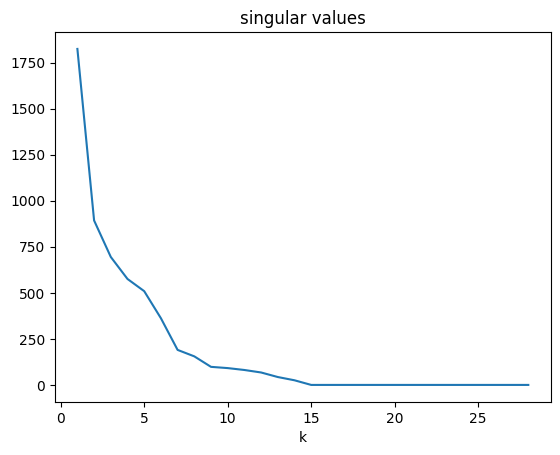

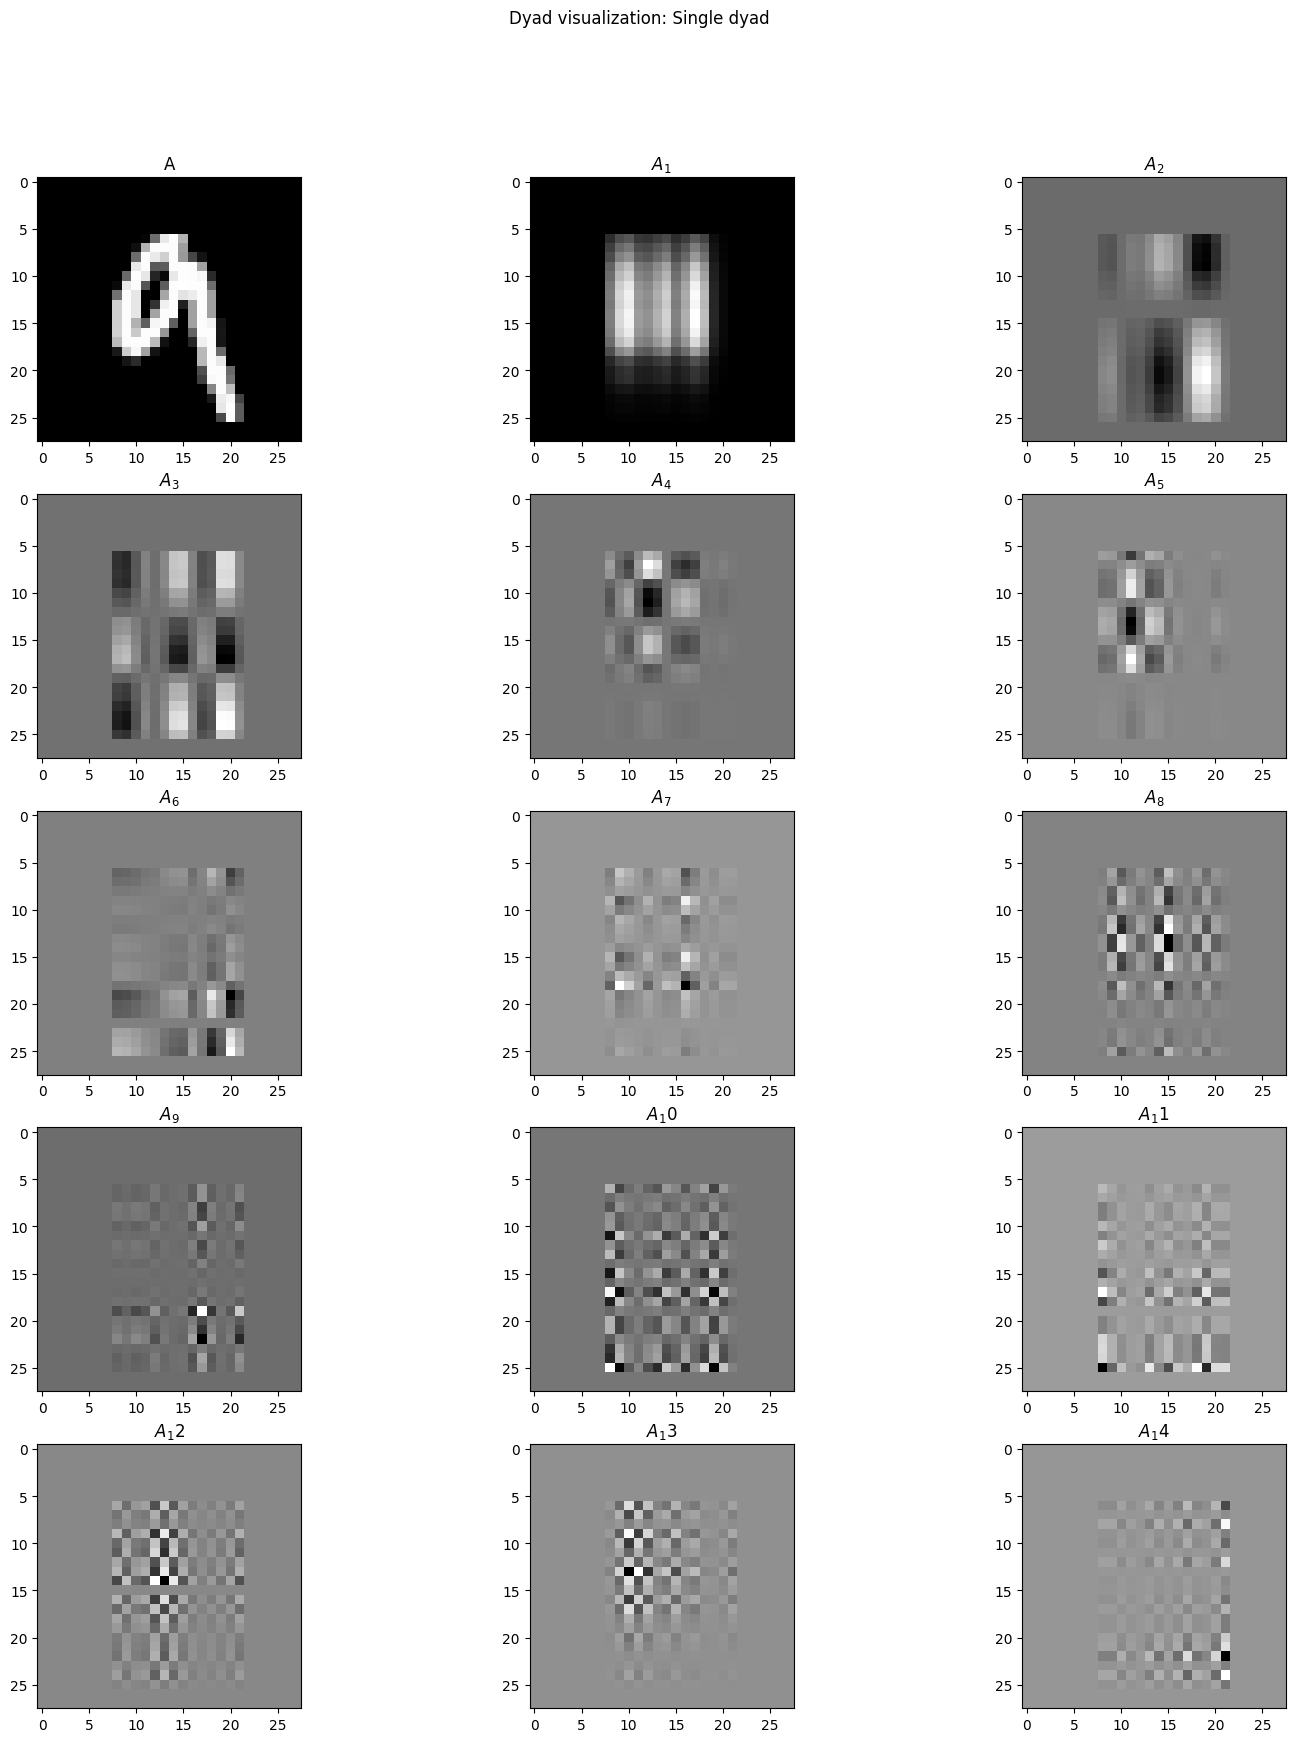

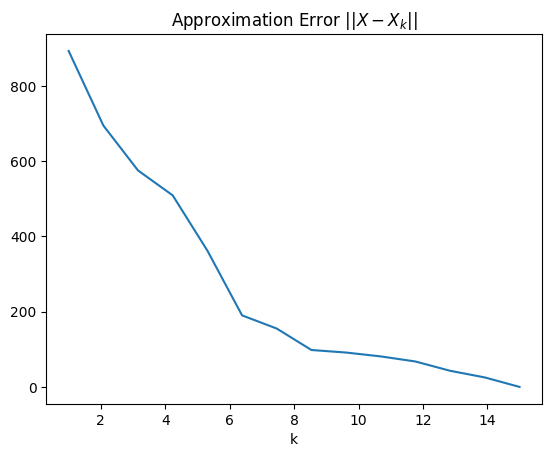

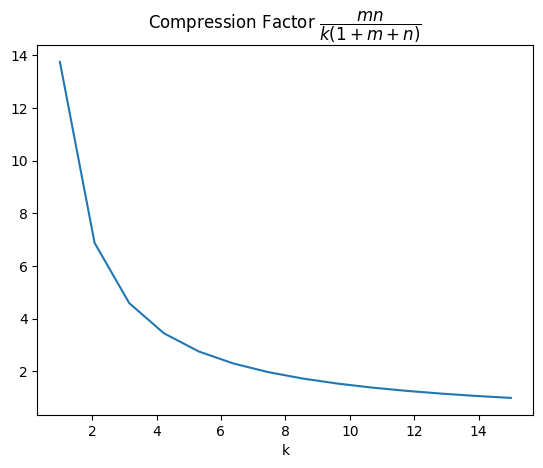

In [20]:
img = X[:, 12001]
img = np.reshape(img, (28, 28))
r = np.linalg.matrix_rank(img)
print("Selected image with matrix rank r= ", r)
U, s, VT = np.linalg.svd(img)
A = np.zeros((28, 28))
print("Singular values:\n", s)

plt.figure()
plt.plot(np.arange(1, 29), s)
plt.title("singular values")
plt.xlabel("k")

niter = r
modes = ['Single dyad', 'k-Approximation']
plot = modes[0]

plt.figure(figsize=(6 * 3, ((niter + 1)//3 + 1) * 4))
plt.suptitle(f"Dyad visualization: {plot}", y= 0.95)
plt.subplot(((niter + 1)//3 + 1), 3, 1)
plt.imshow(img, cmap="gray")
plt.title("A")

err = np.zeros((niter,))
compress = np.zeros((niter,))

for i in range(niter):
    Ai = s[i] * np.outer(U[:, i], VT[i, :])
    A = A + Ai                        # i approx of image
    if plot == 'Single dyad':
        Aplot = Ai
    elif plot == 'k-Approximation':
        Aplot = A
    else:
        break
    plt.subplot(((niter + 1)//3 + 1), 3, i + 2)
    plt.imshow(Aplot, cmap = "gray")
    plt.title(f"$A_{i + 1}$")
    
    err[i] = np.linalg.norm(img - A, 2)
    compress[i] = 28**2/((i+1)* (1+ 28 + 28))


plt.figure()
plt.title("Approximation Error $||X - X_k||$")
plt.plot(np.linspace(1, niter + 1, niter), err)
plt.xlabel("k")
plt.figure()
plt.title("Compression Factor $\dfrac{mn}{k(1 + m + n)}$")
plt.plot(np.linspace(1, niter + 1, niter), compress)
plt.xlabel("k")

plt.show()